# Introduction

While starting to look at Markov Models, I discovered a network able to compute probabilities combined as we usually do manually. It's called Bayesian Models. In this Notebook, I'll experiement this kind of models on small examples and then, we will do a quick "word generator" based on Markov Models

# Bayesian Model

To do Bayesian Model, we should install a specific library called pgmpy. As there is not a lot of documentation about it, let's first try a simple example present on their presentation

In [1]:
import pandas as pd
import numpy as np

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

### Simple example

The first exercice uses data sample to predict a value given a graph. Let's assume that the graph is :

<img src="Bayes_example.png"/>

Let's create a fake dataset and the graph

In [2]:
df = pd.DataFrame(np.random.randint(low=0, high=2, size=(100, 5)),columns=['A', 'B', 'C', 'D', 'E'])
train_data = df[:80].copy()
test_data = df[80:].copy()
model = BayesianModel([('A', 'E'), ('C', 'D'), ('D', 'B'), ('C', 'B'), ('B', 'E')])

Now we can train the model and test it. Of course the result won't be good as the dataset is fully random

In [3]:
model.fit(train_data)
y_true = test_data["E"]
test_data.drop(['E'], axis=1, inplace=True)
y_pred = model.predict_probability(test_data)
result = pd.concat([y_pred, y_true], axis=1)
result.columns = ["pred_0", "pred_1", "y_true"]
result

,pred_0,pred_1,y_true
80,0.478261,0.521739,0
81,0.500000,0.500000,0
82,0.600000,0.400000,0
83,0.478261,0.521739,0
84,0.375000,0.625000,0
85,0.375000,0.625000,0
86,0.600000,0.400000,1
87,0.478261,0.521739,0
88,0.478261,0.521739,1
89,0.500000,0.500000,1


We can also look at Conditionnal Probabilities Distribution. During the fit, it will create table for simple CPDs (like A which is a "root") but also real conditionnal ones like D which depends on D

In [4]:
print(model.get_cpds()[0])

╒══════╤════════╕
│ A(0) │ 0.5125 │
├──────┼────────┤
│ A(1) │ 0.4875 │
╘══════╧════════╛


In [5]:
print(model.get_cpds()[3])

╒══════╤═══════╤══════╕
│ C    │ C(0)  │ C(1) │
├──────┼───────┼──────┤
│ D(0) │ 0.475 │ 0.4  │
├──────┼───────┼──────┤
│ D(1) │ 0.525 │ 0.6  │
╘══════╧═══════╧══════╛


Now, we saw the basic where we use a dataset to handle CPDs but we can also fix CPDs and do prediction. This is what we will do on the 2 next exercices.

### Exercice 1

The exercice comes from <a href="https://www.matthieuamiguet.ch/media/documents/MA-IARTI-TPs-ResBayesiens.pdf">this website</a> and is translated in English below

In the company Bayes & Co, there is a boss that decides periodically to lay off employees or increase the salary of other employees. His politics is not very popular, there are as many dismissals as there are salary increases.

Everytime the boss takes one of these decisions, it must be managed by the Human Resources and Accounting departments, which send together the notification (good or bad).

The human resources department has three employees: Janet, Jim and Julia.
During a layoff, Janet manage 30% of cases, Jim 35% and Julia 35%.
With the salary increase, the proportions increases to 20%, 20% and 60% respectively.

The Accounting department ahs two employees: James and Jules. 
During a layoff, James takes care of 37% of cases (and Jules 63%).
With the salary increase, proportions increase to 42% (and thus 58% for Jules).

Employees can be notified by mail or email. To do so, the two persons in charge of the change agree. 
So we see that Janet and James write a letter in 40% of cases but when Janet collaborates with Jules, these proportions are 70% and 30%. For Jim and James it's 30% and 70%. For Jim and Jules 65% and 35%. For Julia and James
25% and 75% and finally for Julia and Jules, it's 55% and 45%.

First thing, we have to create the graph related. We can extract 4 things :
    - The notification
    - The HR responsible
    - The Accountant responsible
    - The reason
    
Based on that we can do the following graph with related CPDs:
    
<img src="Bayes_ex_1.png"/>

Just an information, in the next steps, names will be integer for modeling purposes. As a result, the index will increased from left to right on the image above so:
- James will be HR_0
- jules will be HR_1
- Janet will be Accounting_0
- and so on

Let's now build the graph:

In [6]:
G = BayesianModel()
G.add_nodes_from(['Reason', 'Accounting', 'HR', 'Notification'])
G.add_edges_from([
                    ('Reason', 'Accounting'), 
                    ('Reason', 'HR'),
                    ('Accounting', 'Notification'),
                    ('HR', 'Notification')
                 ])

And create all CPDs

In [7]:
cpd_a = TabularCPD(variable = 'Reason', variable_card = 2, values = [[0.5], [0.5]])
print(cpd_a)

╒══════════╤═════╕
│ Reason_0 │ 0.5 │
├──────────┼─────┤
│ Reason_1 │ 0.5 │
╘══════════╧═════╛


In [8]:
cpd_b = TabularCPD('Accounting', 2, [[0.37, 0.42], [0.63, 0.58]], evidence=['Reason'], evidence_card=[2])
print(cpd_b)

╒══════════════╤══════════╤══════════╕
│ Reason       │ Reason_0 │ Reason_1 │
├──────────────┼──────────┼──────────┤
│ Accounting_0 │ 0.37     │ 0.42     │
├──────────────┼──────────┼──────────┤
│ Accounting_1 │ 0.63     │ 0.58     │
╘══════════════╧══════════╧══════════╛


In [9]:
cpd_c = TabularCPD('HR', 3, [[0.3, 0.2], [0.35, 0.2], [0.35, 0.6]], evidence=['Reason'], evidence_card=[2])
print(cpd_c)

╒════════╤══════════╤══════════╕
│ Reason │ Reason_0 │ Reason_1 │
├────────┼──────────┼──────────┤
│ HR_0   │ 0.3      │ 0.2      │
├────────┼──────────┼──────────┤
│ HR_1   │ 0.35     │ 0.2      │
├────────┼──────────┼──────────┤
│ HR_2   │ 0.35     │ 0.6      │
╘════════╧══════════╧══════════╛


In [10]:
cpd_d = TabularCPD('Notification', 2, [[0.4, 0.3, 0.25, 0.7, 0.65, 0.55], [0.6, 0.7, 0.75, 0.3, 0.35, 0.45]], evidence=['Accounting', 'HR'], evidence_card=[2, 3])
print(cpd_d)

╒════════════════╤══════════════╤══════════════╤══════════════╤══════════════╤══════════════╤══════════════╕
│ Accounting     │ Accounting_0 │ Accounting_0 │ Accounting_0 │ Accounting_1 │ Accounting_1 │ Accounting_1 │
├────────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ HR             │ HR_0         │ HR_1         │ HR_2         │ HR_0         │ HR_1         │ HR_2         │
├────────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ Notification_0 │ 0.4          │ 0.3          │ 0.25         │ 0.7          │ 0.65         │ 0.55         │
├────────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ Notification_1 │ 0.6          │ 0.7          │ 0.75         │ 0.3          │ 0.35         │ 0.45         │
╘════════════════╧══════════════╧══════════════╧══════════════╧══════════════╧══════════════╧══════════════╛


Now we add the CPDs to the model

In [11]:
G.add_cpds(cpd_a, cpd_b, cpd_c, cpd_d)

We have few options to explore the graph like independencies (2 nodes not connected directly). Their is probably other ones but I didn't checked in detail

In [12]:
G.get_independencies()

(Reason _|_ Notification | HR, Accounting)
(Accounting _|_ HR | Reason)
(HR _|_ Accounting | Reason)
(Notification _|_ Reason | HR, Accounting)

Now we can try to predict something. For example, the probability of being fired if we receive a letter from Jules and Janet

In [13]:
a = pd.DataFrame({"Accounting" : [1], "HR" : [0], "Notification" : [1]})
a

,Accounting,HR,Notification
0,1,0,1


In [14]:
G.predict(a)

,Reason
0,0


The model says that it's more probable to be fire than increased but we don't have a proper probability. To do so, we could think that we can use the method *predict_proba*

In [15]:
G.predict_probability(a)

TypeError: 'NoneType' object is not subscriptable

But this is not working. To do so, we should use another part of the library which is *VariableElimination*

In [16]:
mdl = VariableElimination(G)

Let's now anser the question we have on the exercice

##### Q1
Jeremy received this morning a letter from Janet and Jules. 
What is the probability that it's a layoff letter? (answer : 62%)

In [17]:
r = mdl.query(["Reason"], evidence={"Accounting" :1, "HR": 0, "Notification": 0 })
print(r["Reason"])

╒══════════╤═══════════════╕
│ Reason   │   phi(Reason) │
╞══════════╪═══════════════╡
│ Reason_0 │        0.6197 │
├──────────┼───────────────┤
│ Reason_1 │        0.3803 │
╘══════════╧═══════════════╛


And if it's from Jim and James ? (answer : 61%)

In [18]:
r = mdl.query(["Reason"], evidence={"Accounting" :0, "HR": 1, "Notification": 0 })
print(r["Reason"])

╒══════════╤═══════════════╕
│ Reason   │   phi(Reason) │
╞══════════╪═══════════════╡
│ Reason_0 │        0.6066 │
├──────────┼───────────────┤
│ Reason_1 │        0.3934 │
╘══════════╧═══════════════╛


If all that Jeremy knows is that Julia is in charge of his case, what are the risks of being fired? (answer: 37%)

In [19]:
r = mdl.query(["Reason"], evidence={"HR": 2})
print(r["Reason"])

╒══════════╤═══════════════╕
│ Reason   │   phi(Reason) │
╞══════════╪═══════════════╡
│ Reason_0 │        0.3684 │
├──────────┼───────────────┤
│ Reason_1 │        0.6316 │
╘══════════╧═══════════════╛


Jeremy received an email this morning, but he does not know who handled his case. How likely is it to read a salary increase announcement? (answer: 52%)

In [20]:
r = mdl.query(["Reason"], evidence={"Notification": 1})
print(r["Reason"])

╒══════════╤═══════════════╕
│ Reason   │   phi(Reason) │
╞══════════╪═══════════════╡
│ Reason_0 │        0.4790 │
├──────────┼───────────────┤
│ Reason_1 │        0.5210 │
╘══════════╧═══════════════╛


All results are the one expected and quite easily (except that it's a bit difficult to find the information in the internet).

I tried the second exercice from the same document but without success. There were missing informations (at least to me) or my grpah was not good. So I won't present it at all.

# Markov Model

This kind of graph can be transformed to Markov Model which are using <a href="https://en.wikipedia.org/wiki/Markov_chain">Markov Chain</a>. A simple example of Markov Chain is to generate words similar to a given language. This is what we will do now.

To do so, I'll not create a Markov Model directly with pgmpy because CPDs would be the probability of each following letter given the previous one... which is 26 x 26 values. This will be done by storing probabilities in a Matrix directly. 

Now to create this transition matrix, we will need datas. In some test cases, people are using dictionnary but the problem is that we give the same weight to very common words like "the" or "lycanthropy". To be closer to normal language, I'll use free books in a given language (english). Thousands of books are available on Gutenberg's project (<a href="https://www.gutenberg.org/browse/scores/top">link</a>) so I took 10 random ones. Let's now create the transition matrix

NB : If you want to test Markov Model with pgmpy, you can look at this link :
https://conference.scipy.org/proceedings/scipy2015/pdfs/ankur_ankan.pdf or http://pgmpy.org/_modules/pgmpy/models/MarkovChain.html

In [21]:
import glob
import string
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy

alphabet = string.ascii_lowercase

let's store all words of the 10 books in a list (only character and lowercase)

In [22]:
words = []
for file in glob.glob("data/book/*.txt"):
    with codecs.open(file, 'r', encoding='utf8') as f:
        for line in f:
            line = re.sub(r"[^A-Za-z ]+", "", line.lower())
            words += line.split()

In [23]:
len(words)

932848

So we have 933k words stored, let's take for every letter the next one and store it in the transition matrix

In [24]:
alphabet

'abcdefghijklmnopqrstuvwxyz'

In [25]:
X = np.zeros(shape=(26, 26), dtype=np.int32)
for word in words:
    word = word
    for before, after in zip(word[:-1], word[1:]):
        i = alphabet.index(before)
        j = alphabet.index(after)
        X[i, j] += 1
np.save("X.npy", X)

We can now plot the transition matrix. It's quite common to not plot directly it with number of count but compute the probability per line

In [26]:
X = np.load("X.npy")

In [27]:
p = X / X.sum(axis=1)[:, np.newaxis]

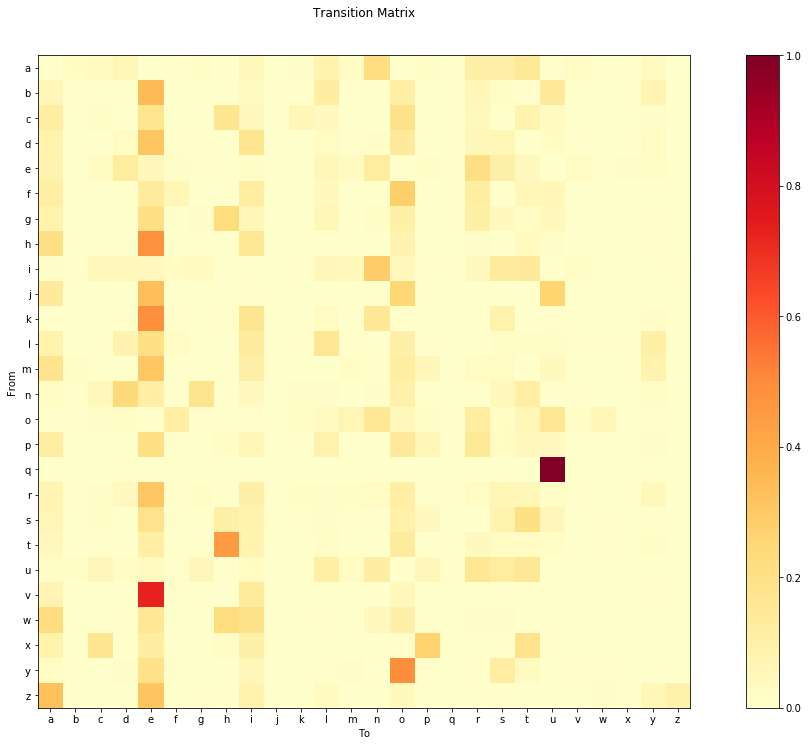

In [28]:
fig, ax = plt.subplots(figsize=(20,12))
im = ax.matshow(p, cmap="YlOrRd")
ax.xaxis.set_ticks_position('bottom')
plt.xticks(range(26), alphabet)
plt.yticks(range(26), alphabet)
plt.xlabel("To")
plt.ylabel("From")
plt.title("Transition Matrix")
plt.colorbar(im)
plt.show()

You can see that it's not very easy to see pattern mainly due to globally 2 big probabilites crushing other probs in the same range. It's because V is nearly often followed by E and Q by U. A way to increase this probability is to add a power $$ V = p^{x}\:with\:0 < x < 1 $$

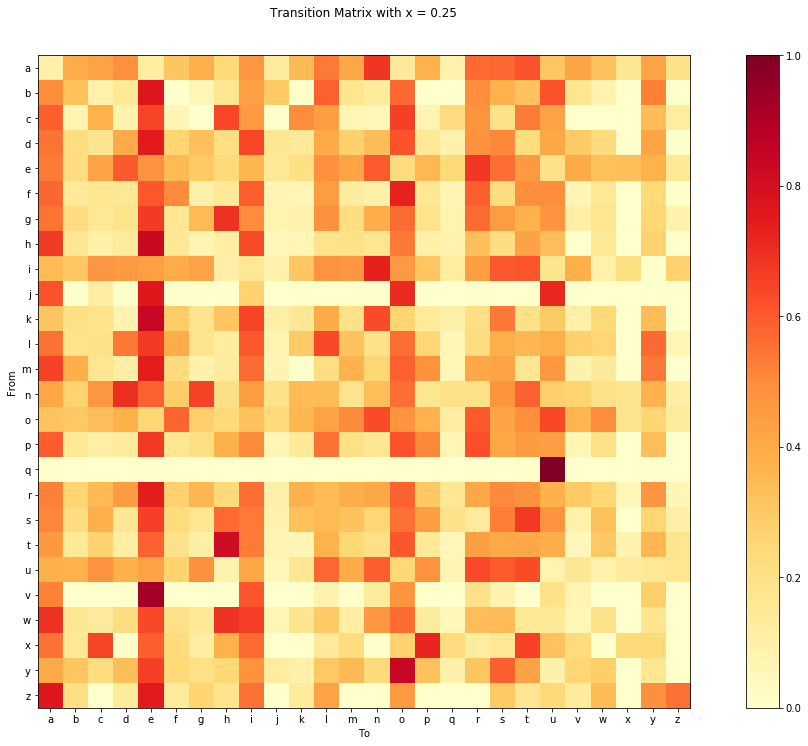

In [29]:
fig, ax = plt.subplots(figsize=(20,12))
im = ax.matshow(p**0.25, cmap="YlOrRd")
ax.xaxis.set_ticks_position('bottom')
plt.xticks(range(26), alphabet)
plt.yticks(range(26), alphabet)
plt.xlabel("To")
plt.ylabel("From")
plt.title("Transition Matrix with x = 0.25")
plt.colorbar(im)
plt.show()

Now we have our transition matrix, to generate random words, we just pick a random letter to start and based on probabilites of the next letter given the previous one, we pick the next one and so on... Let's create this function

In [30]:
def sample(transition, start, maxlen = 7):
    word = start
    index = alphabet.index(start)
    while True:
        row = transition[index]
        index = np.random.choice(np.arange(len(p)), p=row)
        word += alphabet[index]
        if len(word) == maxlen:
            break
    return word

Let's now generate 50 random words of length 7. To simplify, I didn't store probabilites of starting letters but of course we can do the same.

In [31]:
for _ in range(100):
    starting_letter = np.random.choice(list(string.ascii_lowercase))
    print(sample(p, starting_letter))

yblytea
hyollip
jouthes
histint
pedoutc
oreloko
knjanon
cuamiou
jeresui
zesspra
lereand
eatrngr
edyoupe
flvered
uristha
jandoth
haldrth
peatind
mplooll
macalin
ftenour
kntases
quthimp
erarthe
taryoan
merthev
emethey
ineveas
fathent
iveatee
hedenga
xeathre
bongiki
xprered
uinnded
fiootyo
ryomrel
youcorn
blyeret
tarntow
vaderor
zerengl
httisen
kndethf
chantag
derator
pumelfu
quscrsa
adedrec
sepatht
ruthork
meyerin
grsting
lofindr
rangscq
thitepa
zedenow
indiblo
resfowi
zlemnan
gutinon
heiofel
ratandi
heeldin
yoweryo
atherdl
gareesi
rmyhean
cthelth
jundsof
jofelan
golimer
ficsens
umasera
hobonor
oatyonm
cofeayo
nexeded
icalend
ghetopr
qupryen
sthesem
ornicku
enobete
byofeca
wsssool
msprrer
upoerin
jatsthi
woundoj
kyostha
llloure
hedavee
xingggh
ymadowi
kssstin
inojeis
gandere
edtheer
mshentu


just to see the difference, we can also do the same with full random selection

In [32]:
def random_sample(start, maxlen = 7):
    word = start
    while True:
        word += np.random.choice(list(string.ascii_lowercase))
        if len(word) == maxlen:
            break
    return word

for _ in range(50):
    starting_letter = np.random.choice(list(string.ascii_lowercase))
    print(random_sample(starting_letter))

isdqypn
bpovxgj
eldgikg
zhmbycn
ufcxnjt
kjdirpi
fsagdqm
xgedxki
mcnglfm
nhywygj
attnprz
mgsbwje
qjasbou
lkbvliw
kbndzxl
fmjbuol
yabjzpy
ftctcxk
kbmyrql
vqljhcv
foinsxr
urgvuyp
fwiuthy
bibsvio
iowszkh
wcttgcj
vnlvppl
yyuumso
gqomgnx
gkeivwz
qsftvgl
tpnirlp
rlgflki
eejqblt
wzcwkeu
dbuafnc
tebzypt
lixpjub
titwfzs
njauoje
xanlrmz
siecjqv
tidttfr
mxmbgth
mevfmkt
ljxijjb
rtggwsg
tumpjsb
vxafmoj
ecrlhwx


We can see that most of words are not pronounceable with full random selection (eg wdmvqkw or lfwvnud) but a lot more with the transition matrix (eg gerusli or fichelo). Nevertheless, as we didn't consider starting and stopping letter (I only stop at maxlen), some words seems strange like verondr or ctontis. We saw that we need additionnal letters before or after.

# Conclusion

In this Notebook, I wanted to have a look at Bayesian Network I discovered not a long time ago. It's not difficult by itself but the fact that we need to know/setup the graph is quite restrictive in Machine Learning cases where we need to find out pattern from data. 

Anyhow, it's still an available tool to keep in mind in case we knows this. In addition, the documentation is not very important so having this tutorial may help me being faster if I need it someday.

I took advantage of this exercice also to have a look at Markov Model. I haven't done a in-depth exploration but someday I'll try to have a look ad Hidden markov Model often used when we have hidden states.